# Сборный проект - 2. HR-аналитика

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.  
У вас будет несколько задач.  
Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.  
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.  
Теперь расскажем подробнее о задачах.
- Задача 1: предсказание уровня удовлетворённости сотрудника  
Для этой задачи заказчик предоставил данные с признаками:
    - id — уникальный идентификатор сотрудника;
    - dept — отдел, в котором работает сотрудник;
    - level — уровень занимаемой должности;
    - workload — уровень загруженности сотрудника;
    - employment_years — длительность работы в компании (в годах);
    - last_year_promo — показывает, было ли повышение за последний год;
    - last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
    - supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
    - salary — ежемесячная зарплата сотрудника;
    - job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.


- Задача 2  
Для этой задачи вы можете использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

План работы для решения задач аналогичен и строится по плану:

- Загрузка данных
- Предобработка данных
- Исследовательский анализ данных
- Добавление нового входного признака
- Подготовка данных
- Обучение моделей
- Выводы

Необходимо выяснить, чем отличаются сотрудники, неудовлетоворенные работой, от сотрудников, удовлетворенных работой. Модель должна уточнить наши выводы из исследовательского анализа. В итоге должны получиться модели, предсказывающие уровень удовлетворенности сотрудника и вероятность его ухода из компании, а также выводы о том, что влияет на уход сотрудников.

In [1]:
conda install scklearn==1.2 #после этого необходимо рестартнуть ядро (Kernel->Restart the kernel)

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install phik -q
!pip install shap -q
!pip install imblearn -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

from phik import phik_matrix
from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE


# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, fbeta_score, precision_score, recall_score, make_scorer

# импортируем класс GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC

import shap
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

import warnings
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 42

## Предсказание уровня удовлетворенности

In [7]:
def get_var_name(var): #функция для получения имени переменной
    globals_dict = globals()
    return [name for name, value in globals_dict.items() if value is var][0]

def describe_dataset(dataset): #функция для описания данных в датасете
    display(dataset.head(5))
    print(f'Общие сведения о датасете {get_var_name(dataset)}')
    print('---------------------------------------------------------------------------')
    display(dataset.info())
    print(f'\nСатистические данные о датасете {get_var_name(dataset)}')
    print('---------------------------------------------------------------------------')
    display(dataset.describe())
    print(f'\nУникальные значения в столбцах датасете {get_var_name(dataset)}')
    print('---------------------------------------------------------------------------')
    for col in dataset.columns:
        if dataset[col].dtype == 'object':
            print(f'{col}: {len(dataset[col].unique())} уникальных значений')
            if len(dataset[col].unique()) <= 7:
                print(dataset[col].value_counts(), end="\n\n")
            else:
                print(dataset[col].value_counts().head(7), end="\n\n")
            
    print(f'Пропуски в датасете {get_var_name(dataset)}')
    print('---------------------------------------------------------------------------')
    display(pd.DataFrame([round(dataset.isna().mean()*100), dataset.isna().sum()]).T.
    sort_values(by=0, ascending=False).
    rename(columns={0: 'Процент пропусков, %', 1: 'Количество пропусков'}).
    style.format("{:,.2f}").
    background_gradient('coolwarm').
    set_properties(**{'text-align': 'center'}))
    print(f'Явные дубликаты в датасете {get_var_name(dataset)}')
    print('---------------------------------------------------------------------------')
    print(f'Количество строк-дубликатов {dataset.duplicated().sum()} ({round(dataset.duplicated().mean()*100)}%)')

### Выгрузка данных

In [5]:
train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

### Предобработка данных

Исследуем выгруженные данные 

In [8]:
describe_dataset(train_job_satisfaction_rate)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Общие сведения о датасете train_job_satisfaction_rate
---------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None


Сатистические данные о датасете train_job_satisfaction_rate
---------------------------------------------------------------------------


,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000



Уникальные значения в столбцах датасете train_job_satisfaction_rate
---------------------------------------------------------------------------
dept: 6 уникальных значений
sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64

level: 4 уникальных значений
junior    1894
middle    1744
sinior     358
Name: level, dtype: int64

workload: 3 уникальных значений
medium    2066
low       1200
high       734
Name: workload, dtype: int64

last_year_promo: 2 уникальных значений
no     3880
yes     120
Name: last_year_promo, dtype: int64

last_year_violations: 2 уникальных значений
no     3441
yes     559
Name: last_year_violations, dtype: int64

Пропуски в датасете train_job_satisfaction_rate
---------------------------------------------------------------------------


,"Процент пропусков, %",Количество пропусков
id,0.00,0.00
dept,0.00,6.00
level,0.00,4.00
workload,0.00,0.00
employment_years,0.00,0.00
last_year_promo,0.00,0.00
last_year_violations,0.00,0.00
supervisor_evaluation,0.00,0.00
salary,0.00,0.00
job_satisfaction_rate,0.00,0.00


Явные дубликаты в датасете train_job_satisfaction_rate
---------------------------------------------------------------------------
Количество строк-дубликатов 0 (0%)


В тренировочном датасете есть 6 пропусков в указании отдела сотрудника и 4 пропуска в его уровне. Пропуски будут заполнены в пайплайне. Явных дубликатов нет, неявных тоже. Типы данных в норме

In [9]:
describe_dataset(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Общие сведения о датасете test_features
---------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None


Сатистические данные о датасете test_features
---------------------------------------------------------------------------


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000



Уникальные значения в столбцах датасете test_features
---------------------------------------------------------------------------
dept: 7 уникальных значений
sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

level: 4 уникальных значений
junior    974
middle    854
sinior    171
Name: level, dtype: int64

workload: 4 уникальных значений
medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

last_year_promo: 2 уникальных значений
no     1937
yes      63
Name: last_year_promo, dtype: int64

last_year_violations: 2 уникальных значений
no     1738
yes     262
Name: last_year_violations, dtype: int64

Пропуски в датасете test_features
---------------------------------------------------------------------------


,"Процент пропусков, %",Количество пропусков
id,0.00,0.00
dept,0.00,2.00
level,0.00,1.00
workload,0.00,0.00
employment_years,0.00,0.00
last_year_promo,0.00,0.00
last_year_violations,0.00,0.00
supervisor_evaluation,0.00,0.00
salary,0.00,0.00


Явные дубликаты в датасете test_features
---------------------------------------------------------------------------
Количество строк-дубликатов 0 (0%)


В датасете есть пропуски в отделе и уровне сотрудника. Явных и невяных дубликатов нет. Типы данных подходящие

In [10]:
describe_dataset(test_target_job_satisfaction_rate)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Общие сведения о датасете test_target_job_satisfaction_rate
---------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None


Сатистические данные о датасете test_target_job_satisfaction_rate
---------------------------------------------------------------------------


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000



Уникальные значения в столбцах датасете test_target_job_satisfaction_rate
---------------------------------------------------------------------------
Пропуски в датасете test_target_job_satisfaction_rate
---------------------------------------------------------------------------


,"Процент пропусков, %",Количество пропусков
id,0.00,0.00
job_satisfaction_rate,0.00,0.00


Явные дубликаты в датасете test_target_job_satisfaction_rate
---------------------------------------------------------------------------
Количество строк-дубликатов 0 (0%)


Пропусков нет, дубликатов нет, типы данных в норме.

**Вывод:** была произведена выгрузка данных и их предобработка. Состав данных соответствует описанию. В датасетах test_features и train_job_satisfaction_rate были обнаружены пропуски в признаках department и level, они будут заполнены в рамках работы пайплайна

### Исследовательский анализ данных

In [47]:
def num_feature_plot(feature, title, bins=50):
    """
    Строит распределение и диаграмму размаха для количественных признаков
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    fig.suptitle(f"{title}", fontsize=16)
    ax[0].hist(feature, bins=bins, color='b', edgecolor='black')
    ax[0].set_title(f'Гистограмма для признака {title}', fontsize=15)
    ax[0].set_xlabel(title)
    ax[0].set_ylabel('Частота встречаемости')
    
    ax[1].boxplot(feature, vert=False, widths=10, patch_artist=True, boxprops={
    'color': 'black',       # Цвет контура
    'facecolor': 'blue', # Цвет заливки
    'linewidth': 1,       # Ширина контура
    'linestyle': '-',       # Тип линии (например, '-', '--', ':')
    'alpha': 0.7          # Прозрачность
}
                 )
    ax[1].set_title(f'Boxplot для признака {title}', fontsize=15)
    ax[1].set_xlabel(f'{title}')
    plt.show()
    
def descrete_feature_plot(feature, title):
    """
    Строит столбчатую диаграмму распределения для дискретных данных
    """
    feature_filled = feature.fillna('Пропущенные значения')
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.countplot(x=feature_filled, 
                  ax=ax
                  #order=feature_filled.value_counts().index
                 )
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12)
    ax.set_title(f'Столбчатая диаграмма признака {title}', fontsize=14, fontweight='bold')
    ax.set_xlabel(f'{title}')
    ax.set_ylabel('Количество')
    plt.show()

def cat_feature_plot(feature, title):
    """
    Строит круговую диаграмму распределения для категориальных данных
    """
    feature_filled = feature.fillna('Пропущенные значения')
    counts = feature_filled.value_counts()
    fig, ax = plt.subplots(figsize=(8, 6)) 
    ax.pie(feature_filled.value_counts(), 
          labels=feature_filled.unique(), 
          autopct=lambda p: f'{p * sum(feature_filled.value_counts()) / 100:.0f} ({p:.1f}%)')
    ax.set_title(f'Круговая диаграмма признака {title}', fontsize=14, fontweight='bold')
    plt.show()

    
def analyze_col(column, feature_name, bins=50):
    if column.dtype == 'object':
        cat_feature_plot(column, feature_name)
    else:
        print(column.describe())
        if 'int' in str(column.dtype) and len(column.unique()) <= 15:
            descrete_feature_plot(column, feature_name)
        else:
            num_feature_plot(column, feature_name, bins=bins)

Рассмотрим входные признаки поочередно на примере тренировочной выборке и тестовой выборке

In [27]:
train_job_satisfaction_rate.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

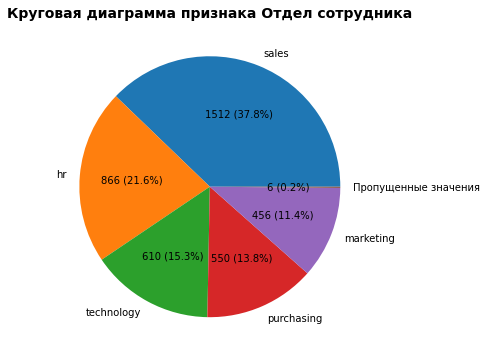

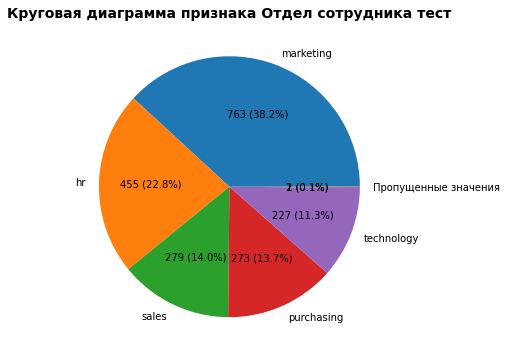

In [35]:
analyze_col(train_job_satisfaction_rate['dept'], 'Отдел сотрудника')
analyze_col(test_features['dept'], 'Отдел сотрудника тест')

Больше всего в компании сотрудников в отделе продаж. В тестовом датасете меньше сотрудников из отдела продаж, преобладают сотрудники из отдела маркетинга.

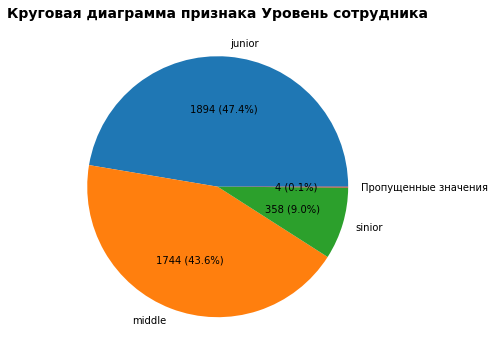

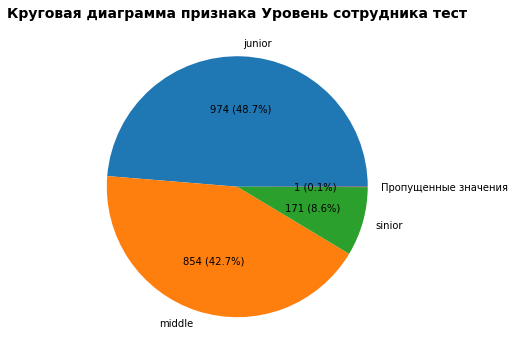

In [36]:
analyze_col(train_job_satisfaction_rate['level'], 'Уровень сотрудника')
analyze_col(test_features['level'], 'Уровень сотрудника тест')

Почти половина сотрудников в компании - джуны. Меньше 10% имеют высший уровень.

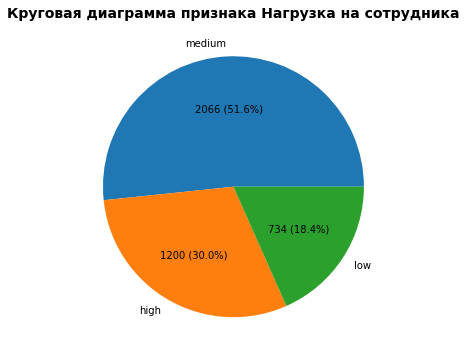

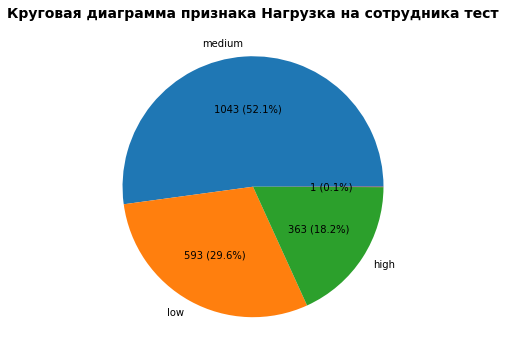

In [37]:
analyze_col(train_job_satisfaction_rate['workload'], 'Нагрузка на сотрудника')
analyze_col(test_features['workload'], 'Нагрузка на сотрудника тест')

Более половины сотрудников испытывают средни уровень нагрузки. Только 18% низко нагружены

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


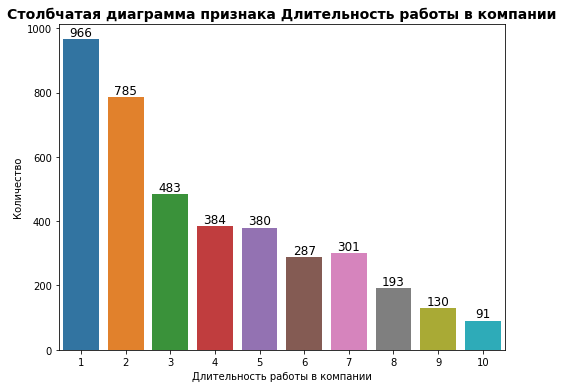

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


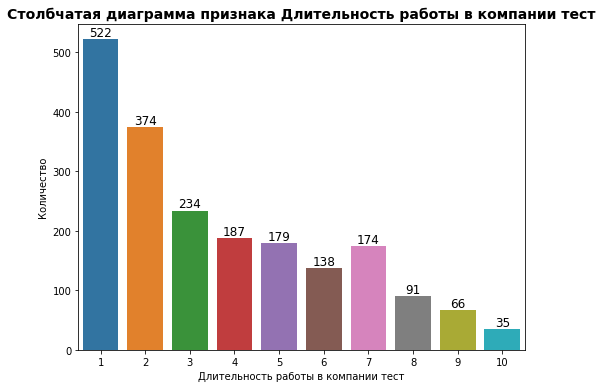

In [48]:
analyze_col(train_job_satisfaction_rate['employment_years'], 'Длительность работы в компании')
analyze_col(test_features['employment_years'], 'Длительность работы в компании тест')

Признак числовой дискретный. Больше всего сотрудников, работающих в компании год-два. В среднем 3,7 лет в компании, медиана - 3 года.

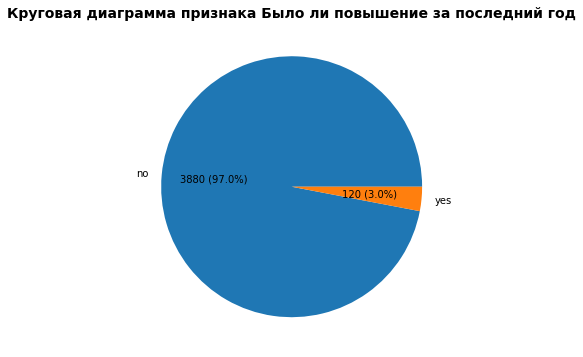

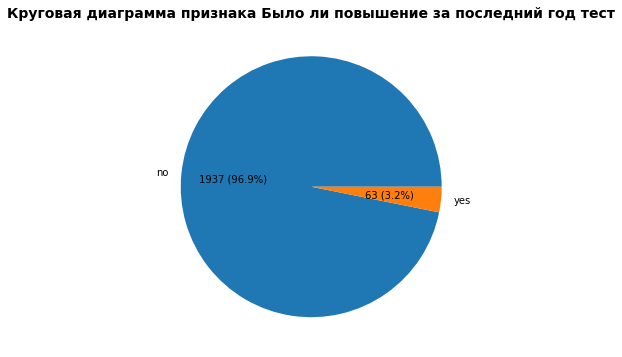

In [39]:
analyze_col(train_job_satisfaction_rate['last_year_promo'], 'Было ли повышение за последний год')
analyze_col(test_features['last_year_promo'], 'Было ли повышение за последний год тест')

Всего 3% сотрудников получили повышение за последний год

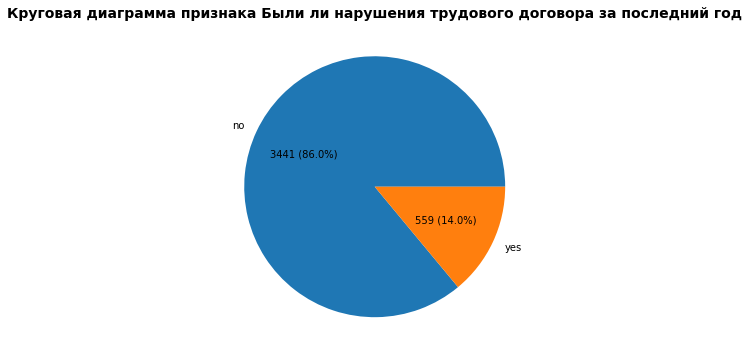

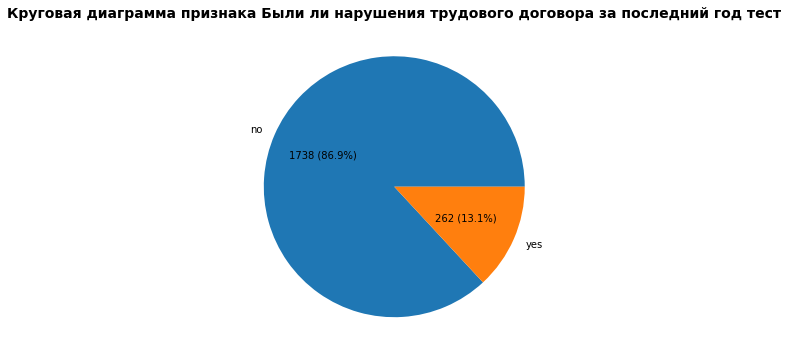

In [40]:
analyze_col(train_job_satisfaction_rate['last_year_violations'], 'Были ли нарушения трудового договора за последний год')
analyze_col(test_features['last_year_violations'], 'Были ли нарушения трудового договора за последний год тест')

14% сотрудников нарушали трудовой договор за последний год. Не совсем ясно как и каковва тяжесть, но подробного описания этого нет.

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


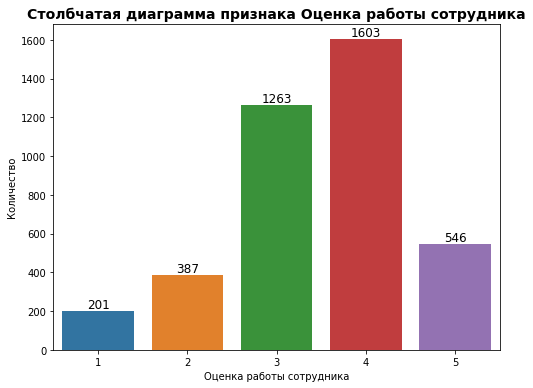

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


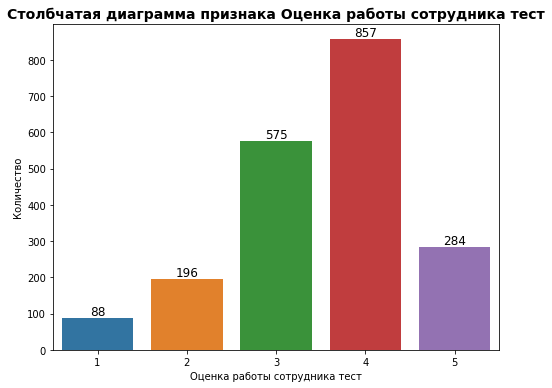

In [49]:
analyze_col(train_job_satisfaction_rate['supervisor_evaluation'], 'Оценка работы сотрудника')
analyze_col(test_features['supervisor_evaluation'], 'Оценка работы сотрудника тест')

Медианная оценка равна 4, что выглядит не так плохо. Однако есть сотрудники с оценкой 1

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64


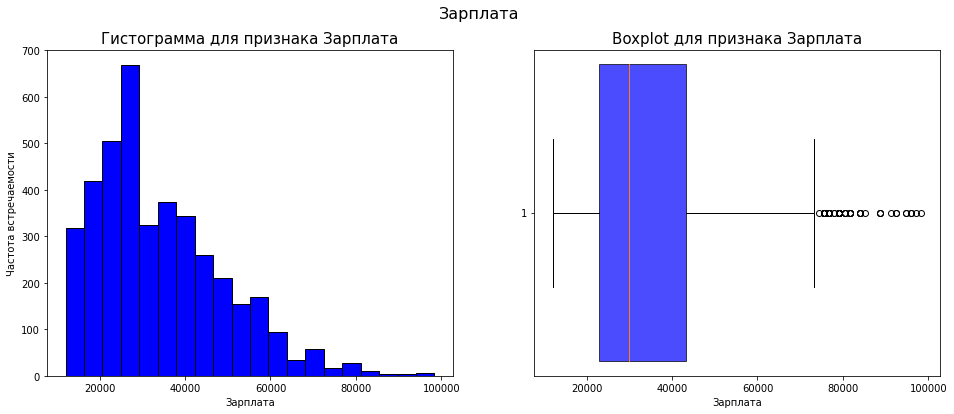

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


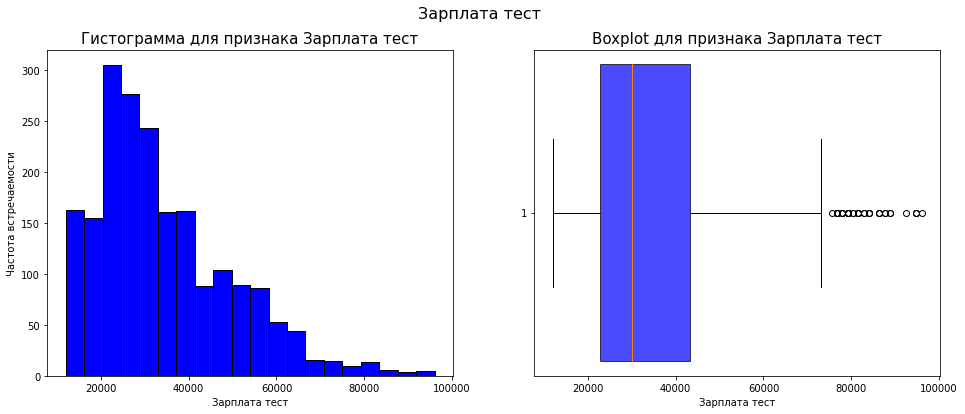

In [50]:
analyze_col(train_job_satisfaction_rate['salary'], 'Зарплата', bins=20)
analyze_col(test_features['salary'], 'Зарплата тест', bins=20)

Минимальная зарпалата 12000, а макимальная 98400. В среднем примерно 34000. Выбросы есть, что в целом достаточно естественно для зарплат, особенно, если учесть руководителей

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


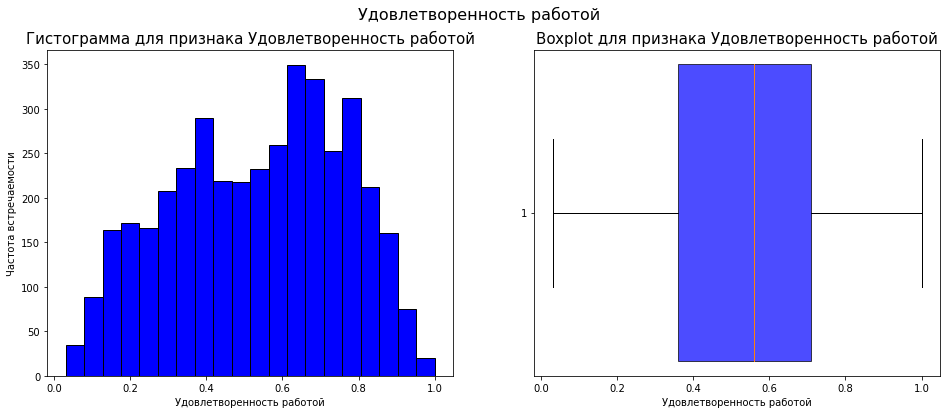

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64


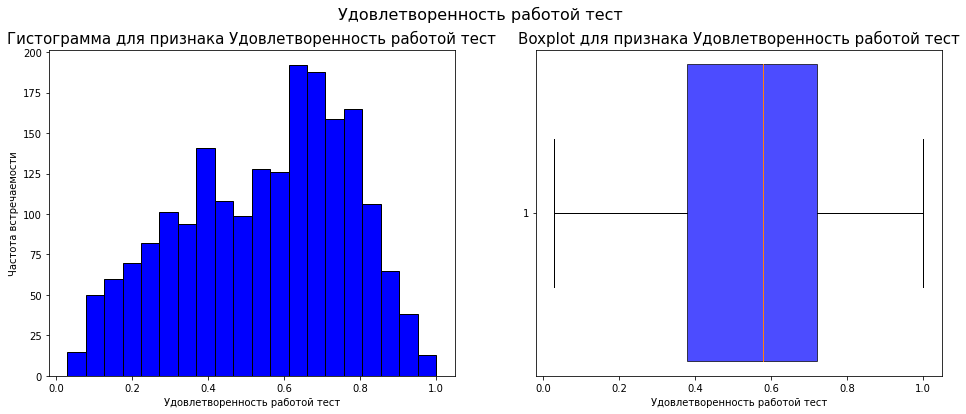

In [289]:
analyze_col(train_job_satisfaction_rate['job_satisfaction_rate'], 'Удовлетворенность работой', bins=20)
analyze_col(test_target_job_satisfaction_rate['job_satisfaction_rate'], 'Удовлетворенность работой тест', bins=20)

В среднем - 0,53, при этом половина сотрудников имеет удовлетворенность больше 0,56. В основном значения сконцентрированы в правой части гистограммы

Проведем корреляционный анализ признаков

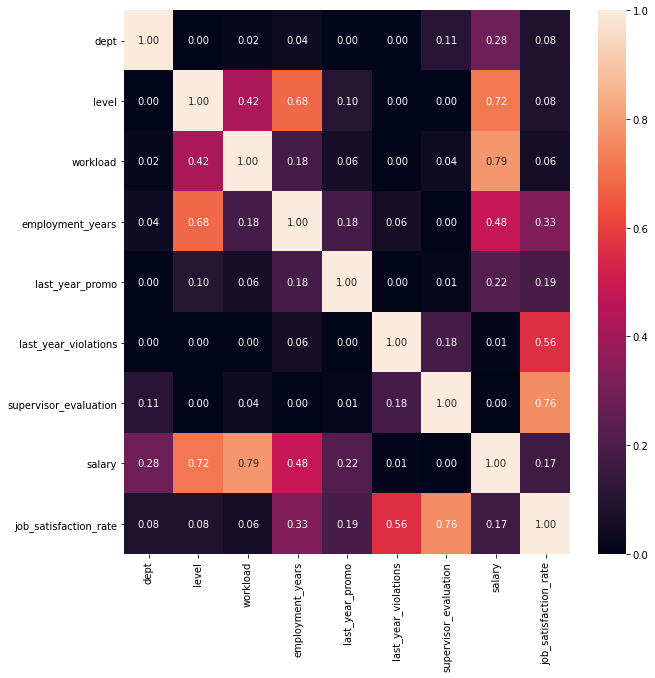

In [51]:
interval_cols = {
    'salary',
    'job_satisfaction_rate'
}


plt.figure(figsize=(10, 10))

sns.heatmap(
    train_job_satisfaction_rate.drop('id', axis=1).phik_matrix(
        interval_cols=interval_cols
    ), annot=True, fmt='.2f'
)

plt.show()

Видим, что наибольший уровень корреляции с целевым признаком у supervisor_evaluation . Также присутствует сильная связь между уровнем зарплаты, стажем работы, уровнем сотрудника и нагрузкой. Однако эта связь не критична, чтобы считать это мультиколлинеарностью.  
Утечки целевого признака нет

**Вывод:**  
Распределение признаков в тренировочном и тестовом датасетах очень похожи, за исключением отделов сотрудников. 
Данные по распределению выглядят достоверно, несмотря на выборсы в признаках salary и supervisor_evaluation.  

Утечки целевого признака нет. Наибольший уровень корреляции у целевого признака с оценкой руководителя. Возможно, если сотрудника хорошо оценивает руководитель, то и сотрудник чувствует себя более комфортно.

При кодировании признаков стоит использовать OneHotEncoder для признаков last_year_violations, last_year_promo и dept, а для кодирования признаков level и workload стоит использовтаь OrdinalEncoder, имея в виду, что признак ранговый

### Построение пайплайна

Подготовим выборки к обучению

In [52]:
temp = train_job_satisfaction_rate
temp = train_job_satisfaction_rate.sort_values('id').reset_index(drop=True).drop('id', axis=1)
temp.drop_duplicates()

X_train = temp.drop(['job_satisfaction_rate'], axis=1)
y_train = temp['job_satisfaction_rate']

temp2 = test_features.merge(test_target_job_satisfaction_rate, on='id', how='inner')
temp2 = temp2.sort_values(by='id').reset_index(drop=True).drop('id', axis=1)

X_test = temp2.drop(['job_satisfaction_rate'], axis=1)
y_test = temp2['job_satisfaction_rate']


In [53]:
ohe_columns = [
    'last_year_violations', 
    'last_year_promo',
    'dept'
]
ord_columns = [
    'workload',
     'level'
]
num_columns = ['salary', 'employment_years', 'supervisor_evaluation'] 

Начнём подготовку пайплайна с создания OHE кодировщика

In [54]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

Теперь перейдём к созданию OrdinalEncoder

In [55]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['low', 'medium', 'high'],
                    ['junior', 'middle', 'sinior']
                    
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Создадим пайплайн для преобработки данных

In [56]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Создадим итоговый пайплан

In [57]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

**Вывод:**  
Был создан пайплайн для преодобработки данных и обучения модели: были учтены особенности данных, отмеченные при исследовательском анализе, а также проведена работа с пропусками данных. 

### Обучение моделей

Напишем функцию для вычисления метрики SMAPE

In [58]:
def smape(y_true, y_pred):
    num = np.abs(y_pred - y_true)
    denom = (np.abs(y_pred) + np.abs(y_true)) / 2
    mask = denom == 0
    denom[mask] = 1  # избегаем деления на 0
    num[mask] = 0    # если оба значения 0, ошибка = 0
    return 100 * np.mean(num / denom)

In [59]:
smape_scorer = make_scorer(smape, greater_is_better=False)

Воспользуемся подбором гипепараметров моделей GridSearchCV

In [60]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5,20),
        'models__max_features': range(5,20),
        'models__min_samples_leaf': range(1,20),
        'models__min_samples_split': range(1,20), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
 
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe__ohe__drop': ['first']
    }
]


In [61]:
grid = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1,
    n_iter=100
)
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['last_year_violations',
                                                                                'last_year_promo',
                                                                                'dept']),
                                                                              ('ord',
                                                                               Pip...
                                         'models__min_samples_leaf': range(1, 20),
                                         'models__min_samples_split': range(1, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough'],
                                         'preprocessor__ohe__ohe__drop': ['first']}],
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [62]:
print(grid.best_estimator_)
print('Метрика SMAPE при кросс-валидации: ', abs(grid.best_score_))
print('Метрика SMAPE на тренировочных данных данных: ', smape(y_train, grid.best_estimator_.predict(X_train)))
print('Метрика SMAPE на тестовых данных: ', smape(y_test, grid.best_estimator_.predict(X_test)))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                                                  Pipeline(s

In [63]:
res = pd.DataFrame(grid.cv_results_)
res.mean_test_score = res.mean_test_score * -1
res.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__min_samples_split,param_models__min_samples_leaf,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.028792,0.003230,0.013654,0.001109,passthrough,9,3,14,16,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",-14.250814,-13.909700,-14.269387,-15.792559,-14.730527,14.590597,0.655216,1
87,0.030740,0.001783,0.017700,0.002384,MinMaxScaler(),7,2,11,18,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",-14.400451,-14.100395,-14.642830,-15.137990,-14.711371,14.598607,0.344409,2
97,0.032653,0.003286,0.014320,0.000417,StandardScaler(),5,2,11,17,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-14.387830,-14.422657,-14.689569,-15.290566,-14.625553,14.683235,0.324771,3
38,0.031011,0.002963,0.014302,0.000516,StandardScaler(),7,6,11,16,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-14.567618,-14.122217,-14.426627,-15.707308,-14.650468,14.694848,0.537230,4
75,0.064575,0.021732,0.019842,0.010234,passthrough,13,3,18,18,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",-14.557328,-14.404190,-14.229379,-16.192203,-14.535834,14.783787,0.713844,5


Исследуем влияние признаков на результат

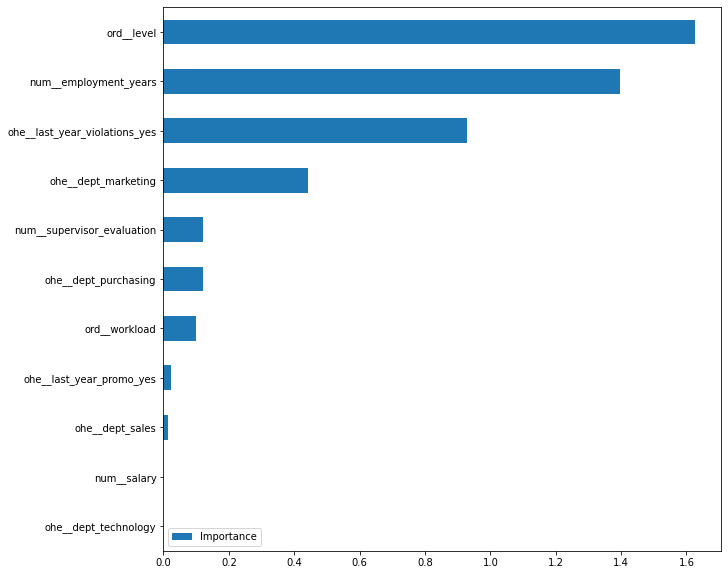

In [64]:
X_train_preprocessed = pipe_final.named_steps['preprocessor'].fit_transform(X_train)

X_test_preprocessed = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=feature_names)

result = permutation_importance(grid.best_estimator_['models'], X_test_preprocessed, y_test, scoring=smape_scorer)
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(result['importances_mean'])})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 10), ylabel='', xlabel='')
plt.show()

**Вывод:**

Наилучшей моделью стало дерево решений с параметрами: 
- max_depth=14, 
- max_features=11,
- min_samples_leaf=1, 
- min_samples_split=8,
- random_state=42

Численные признаки масштабировались MinMaxScaler, к столбцам 'last_year_violations', 'last_year_promo', 'dept' был применён OneHotEncoder, к остальным категориальным признакам OrdinalEncoder

Метрики качества при этом равны: 
- SMAPE на тренировочных данных:  10.01%
- SMAPE на тестовых данных:  13.59%

Видно, что с увеличиением максимальной глубины дерева метрика возрастатет. 
Во многом результат у дерева решенйи лучше в силу количества настраиваемых гиперпараметров. Стоит помнить, что в этой задаче много категориальных признаков, которые линейной регрессии трудно обрабатывать. В то время как дерево решений спокойно работает с такими данными 

Наибольшим влиянием на результат обладают оценка руководителя, длительность работы в компании, наличие нарушений трудовго договора за последний год и уровень. Стоит понимать, что оценка руководителя, наличие нарушений и длительность работы - это, скорее, маркеры, нежели причины. 

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Важно проверить лучшую модель на "адекватность", сравнив качество её предсказаний с качеством модели, которая предсказывала бы константу - вдруг окажется, что не было бы большого смысла заниматься созданием новых признаков, тюнингом и кросс-валидацией моделей, если можно было бы просто предсказывать среднее значение тренировочной выборки? 
    
В качестве константной модели можно использовать DummyRegressor: 

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) -  эта модель как раз создана для генерирования константных предсказаний.
    
Важно, чтобы результат тестирования нашей модели на тествой выборке был лучше, чем результат константной модели - в противном случае наша модель является бесполезной, так как все наши усилия над проектом не принесли результата, а можель, просто предсказывющая среднее на train, делает нашу работу лучше.
</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Раздел - СУПЕР! Пайплайны, трансформеры - современный технологичный способ упаковки кода моделей и подбора гиперпараметров (ГП). Метрика проекта также запрограммирована согласно ТЗ, лучшая модель подобрана на кросс-валидации и подтвержден результат на тестовой выборке.
</div>

## Предсказание увольнения сотрудника из компании

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Дмитрий, здесь по сути начинается 2я часть (очень похожая на 1ю) проекта - загрузка данных, предобработка, EDA, подготовка данных. Ну а раз всё очень похоже - я не буду повторно комментировать аналогичный код ... но отмечу проблемные места, если такие встречу.
</div>

### Выгрузка данных

In [65]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

**Вывод:** Данные выгружены

### Предобработка данных

In [66]:
describe_dataset(train_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Общие сведения о датасете train_quit
---------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None


Сатистические данные о датасете train_quit
---------------------------------------------------------------------------


,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000



Уникальные значения в столбцах датасете train_quit
---------------------------------------------------------------------------
dept: 5 уникальных значений
sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64

level: 3 уникальных значений
junior    1949
middle    1694
sinior     357
Name: level, dtype: int64

workload: 3 уникальных значений
medium    2118
low       1208
high       674
Name: workload, dtype: int64

last_year_promo: 2 уникальных значений
no     3887
yes     113
Name: last_year_promo, dtype: int64

last_year_violations: 2 уникальных значений
no     3455
yes     545
Name: last_year_violations, dtype: int64

quit: 2 уникальных значений
no     2872
yes    1128
Name: quit, dtype: int64

Пропуски в датасете train_quit
---------------------------------------------------------------------------


,"Процент пропусков, %",Количество пропусков
id,0.00,0.00
dept,0.00,0.00
level,0.00,0.00
workload,0.00,0.00
employment_years,0.00,0.00
last_year_promo,0.00,0.00
last_year_violations,0.00,0.00
supervisor_evaluation,0.00,0.00
salary,0.00,0.00
quit,0.00,0.00


Явные дубликаты в датасете train_quit
---------------------------------------------------------------------------
Количество строк-дубликатов 0 (0%)


В датасете train_quit нет ни дубликатов, ни пропусков. Типы данных соответствуют необходимым

In [67]:
describe_dataset(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Общие сведения о датасете test_features
---------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None


Сатистические данные о датасете test_features
---------------------------------------------------------------------------


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000



Уникальные значения в столбцах датасете test_features
---------------------------------------------------------------------------
dept: 7 уникальных значений
sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

level: 4 уникальных значений
junior    974
middle    854
sinior    171
Name: level, dtype: int64

workload: 4 уникальных значений
medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

last_year_promo: 2 уникальных значений
no     1937
yes      63
Name: last_year_promo, dtype: int64

last_year_violations: 2 уникальных значений
no     1738
yes     262
Name: last_year_violations, dtype: int64

Пропуски в датасете test_features
---------------------------------------------------------------------------


,"Процент пропусков, %",Количество пропусков
id,0.00,0.00
dept,0.00,2.00
level,0.00,1.00
workload,0.00,0.00
employment_years,0.00,0.00
last_year_promo,0.00,0.00
last_year_violations,0.00,0.00
supervisor_evaluation,0.00,0.00
salary,0.00,0.00


Явные дубликаты в датасете test_features
---------------------------------------------------------------------------
Количество строк-дубликатов 0 (0%)


В датасете есть пропуски в отделе и уровне сотрудника. Явных и невяных дубликатов нет. Типы данных подходящие

In [68]:
describe_dataset(test_target_quit)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Общие сведения о датасете test_target_quit
---------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None


Сатистические данные о датасете test_target_quit
---------------------------------------------------------------------------


,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000



Уникальные значения в столбцах датасете test_target_quit
---------------------------------------------------------------------------
quit: 2 уникальных значений
no     1436
yes     564
Name: quit, dtype: int64

Пропуски в датасете test_target_quit
---------------------------------------------------------------------------


,"Процент пропусков, %",Количество пропусков
id,0.00,0.00
quit,0.00,0.00


Явные дубликаты в датасете test_target_quit
---------------------------------------------------------------------------
Количество строк-дубликатов 0 (0%)


Датасет в полном порядке. Нет необходимости в предобработке

**Вывод:**
Выгружены необходимые данные. Состав соответствует предоставленному описанию. Требуется обработка пропусков, которая будет произведена в пайплайне

### Исследовательский анализ данных

#### Исследование столбцов в датасетах

In [69]:
train_quit.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit'],
      dtype='object')

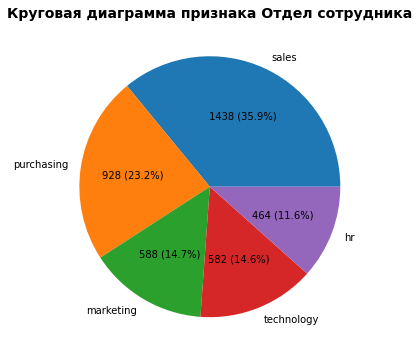

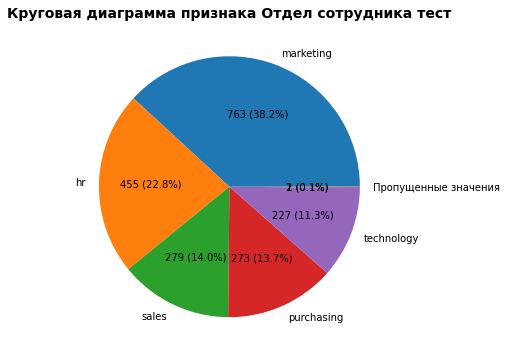

In [70]:
analyze_col(train_quit['dept'], 'Отдел сотрудника')
analyze_col(test_features['dept'], 'Отдел сотрудника тест')

Распределение по отделам в тестовой и тренировочной выборках различается. Однако не критично. Серьезных перевесов нет

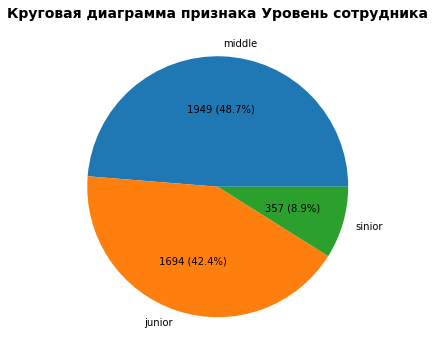

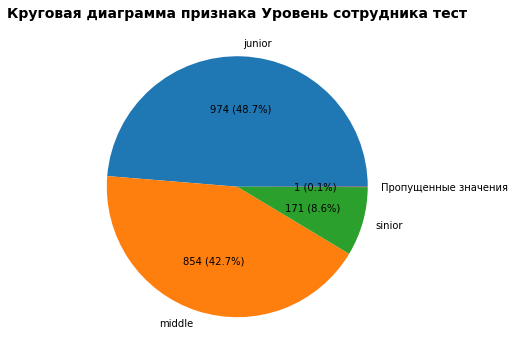

In [71]:
analyze_col(train_quit['level'], 'Уровень сотрудника')
analyze_col(test_features['level'], 'Уровень сотрудника тест')

В тренировочном датасете преобладают сотрудники уровня middle, в то время как в тестовом преобладают джуны. Сотрудники высокой квалификации примерно в одинаковом соотношении

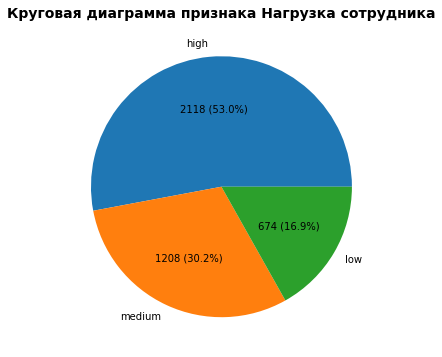

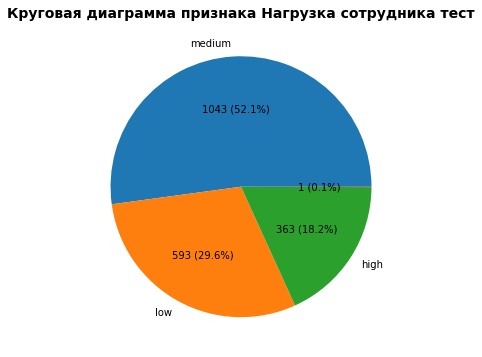

In [72]:
analyze_col(train_quit['workload'], 'Нагрузка сотрудника')
analyze_col(test_features['workload'], 'Нагрузка сотрудника тест')

В тестовом датасете преобладают сотрудники со средним уровнем нагрузки, в то время как в тренировочном - с высоким. В тестовом же наоборот с высоким уровнем - самая небольшая категория

count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


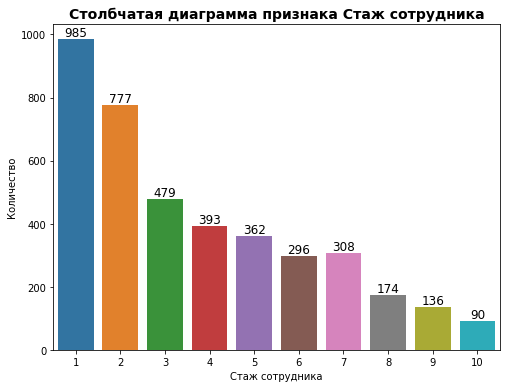

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


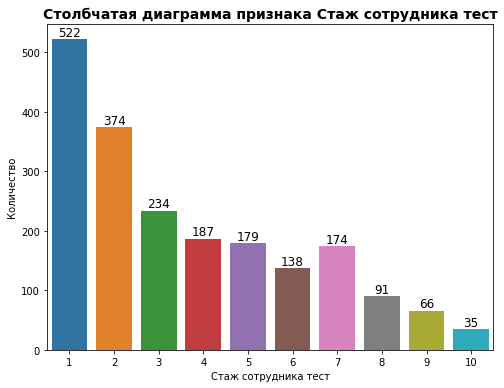

In [73]:
analyze_col(train_quit['employment_years'], 'Стаж сотрудника')
analyze_col(test_features['employment_years'], 'Стаж сотрудника тест')

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

Это дискретный признак.
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

Распределение признака схоже в обоих датасетах. Преобладают сотрудники, которые работают в компании менее 3 лет.

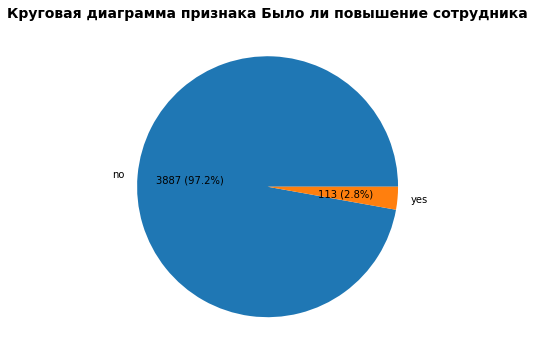

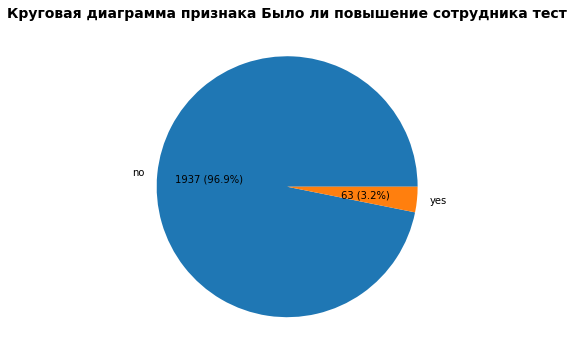

In [74]:
analyze_col(train_quit['last_year_promo'], 'Было ли повышение сотрудника')
analyze_col(test_features['last_year_promo'], 'Было ли повышение сотрудника тест')

В обоих датасетах повышение было примерно у 3% сотрудников

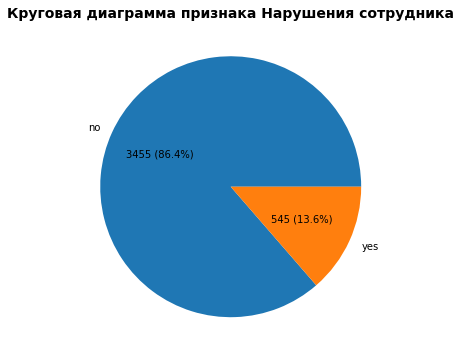

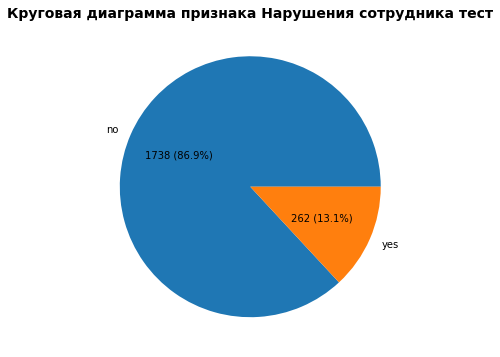

In [75]:
analyze_col(train_quit['last_year_violations'], 'Нарушения сотрудника')
analyze_col(test_features['last_year_violations'], 'Нарушения сотрудника тест')

Распределения признака в обоих датасетах совпадают

count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


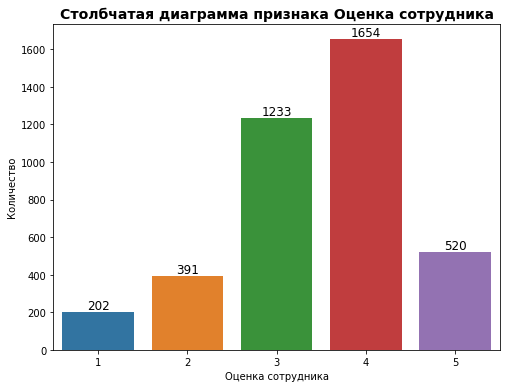

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


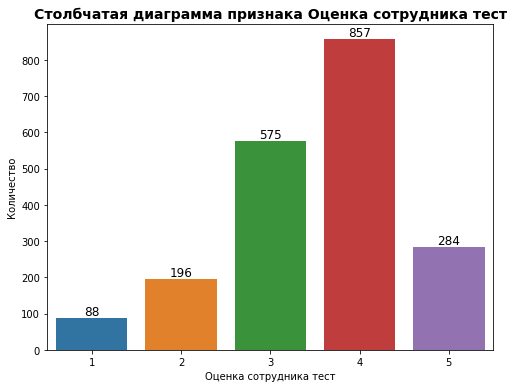

In [76]:
analyze_col(train_quit['supervisor_evaluation'], 'Оценка сотрудника')
analyze_col(test_features['supervisor_evaluation'], 'Оценка сотрудника тест')

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

Это дискретный признак.
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

Распределение признака схожи. Есть выбросы, но они ожидаемы и не критичны

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


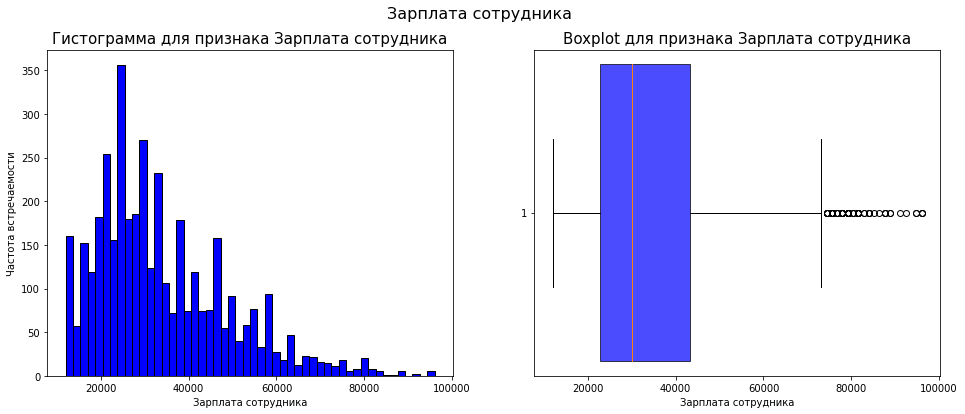

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


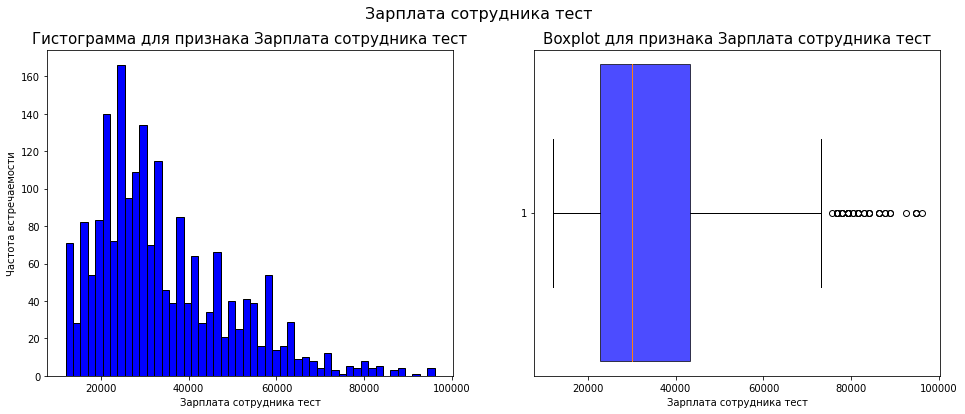

In [77]:
analyze_col(train_quit['salary'], 'Зарплата сотрудника')
analyze_col(test_features['salary'], 'Зарплата сотрудника тест')

Распределения схожи в обоих датасетах. Выбросы вполне объяснимы тем, что руководителей много меньше, чем линейных сотрудников, но заработные платы у них, как правило больше

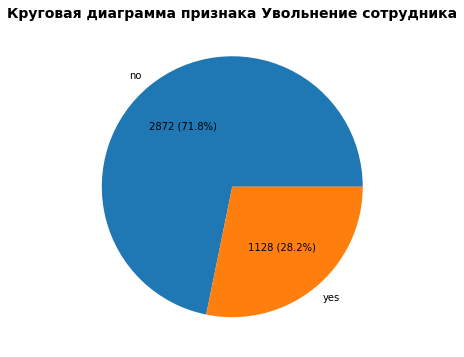

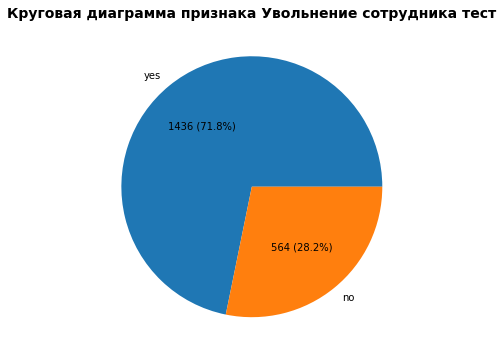

In [78]:
analyze_col(train_quit['quit'], 'Увольнение сотрудника')
analyze_col(test_target_quit['quit'], 'Увольнение сотрудника тест')

Распределения признака схожи. Наблюдается дисбаланс классов, но выборки уже стратифицированны. При неудовлетворительном качестве можно использовать веса классов

#### Портрет уволенного сотрудника

In [93]:
def num_feature_plot_hue(dataset, feature, bins=50, hue=None):
    """
    Строит распределение и диаграмму размаха для количественных признаков
    """
    for h in dataset[hue].unique():
        print(f'Среднее значение признака {feature} в категории {h}: {dataset[dataset[hue] == h][feature].mean()}')
    plt.figure(figsize=(12, 6))
    sns.histplot(data=dataset, 
             x=feature, 
             hue=hue,
             element='step', 
             stat='density', 
             common_norm=False, 
             alpha=0.6)
    plt.title(f"Распределение признака {feature} по категориям {hue}")
    plt.show()

def descrete_feature_plot_hue(dataset, feature, hue=None):
    """
    Строит столбчатую диаграмму распределения для дискретных данных
    """
    dataset[feature] = dataset[feature].fillna('Пропущенные значения')
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.countplot(data=dataset,
                  x=feature, 
                  ax=ax,
                  hue='quit'
                  #order=feature_filled.value_counts().index
                 )
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12)
    ax.set_title(f'Столбчатая диаграмма признака {feature}', fontsize=14, fontweight='bold')
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('Количество')
    if hue:
        plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
def cat_feature_plot_hue(dataset, feature_name, hue=None):
    hues = dataset[hue].unique()
    dataset[feature_name] = dataset[feature_name].fillna('Пропущенные значения')
# Настройки шрифта
    font_properties = {
        'family': 'DejaVu Sans',  # Шрифт
        'size': 18,         # Размер
        'weight': 'normal',   # Жирность 
        'color': 'black'    # Цвет
    }

    
    f, ax = plt.subplots(1, len(hues))

    #подпись общего графика, установка размера окна
    f.suptitle(f'Распределение признака {feature_name} по категориям {hue}', fontsize=32)
    f.set_size_inches(30, 10)
    all_categories = dataset[feature_name].unique()
    colors_list = ['blue', 'orange', 'green', 'red', 'purple', 'cyan', 'yellow', 
                  'magenta', 'lime', 'pink', 'brown', 'gray', 'olive', 'navy']
    category_colors = {}
    for j, category in enumerate(all_categories):
        category_colors[category] = colors_list[j % len(colors_list)]
    
    for i in range(len(hues)):
        hue_data = dataset[dataset[hue] == hues[i]]
        value_counts = hue_data[feature_name].value_counts(normalize=True)
        categories_in_hue = value_counts.index.tolist()
        
        colors_to_use = [category_colors[cat] for cat in categories_in_hue]
        ax[i].set_title(hues[i], fontsize=20)
        ax[i].pie(dataset[dataset[hue] == hues[i]][feature_name].value_counts(normalize=True), 
          labels=dataset[dataset[hue] == hues[i]][feature_name].unique(), 
          autopct=lambda p: f'{p * sum(dataset[dataset[hue] == hues[i]][feature_name].value_counts()) / 100:.0f} ({p:.1f}%)',
          textprops=font_properties,
            colors=colors_to_use)

    plt.show()
    
def analyze_col_hue(dataset, feature_name, bins=50, hue=None):
    if dataset[feature_name].dtype == 'object':
        cat_feature_plot_hue(dataset, feature_name, hue)
    else:
        if 'int' in str(dataset[feature_name].dtype) and len(dataset[feature_name].unique()) <= 15:
            descrete_feature_plot_hue(dataset, feature_name, hue=hue)
        else:
            print(dataset[feature_name].describe())
            num_feature_plot_hue(dataset, feature_name, bins=bins, hue=hue)
        



<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>
    
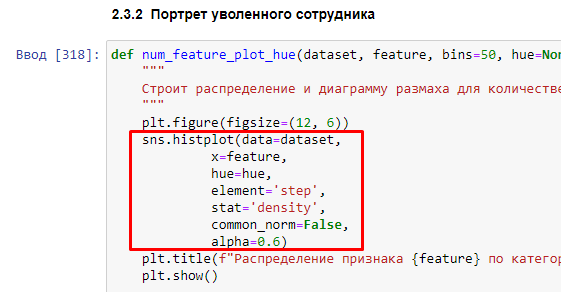    

Отлично, молодец, верно выполнено! 
    
Действительно, в случае сравнения - анализ нужно сделать с помощью относительных величин - оперировать абсолютными величинами не всегда удобно, так как в зависимости от масштаба исследования (компания на 100 человек и компания на 100 000 человек, например) результаты могут быть более или менее интерпретируемыми. Для категориальных/дискретных признаков мы можем использовать **value_counts(normalize=True)**, для непрерывных также стоит посчитать и сравнить средние.

**(ТЕОРИЯ) в зависимости от типа признака:**   
    
- Для анализа распределения **непрерывых величин** (у нас это например `salary`) стоит использовать нормированную гистограмму (например, `shs.histplot()` с параметрами `stat='density', common_norm=False` или `sns.kdeplot()`): гистограммы такого типа позволяют нивелировать разницу в размерах выборок при анализе распределений. Обрати также внимание, что при использовании нормированных гистограмм по оси Y будет уже не частота значений, а плотность распределения.

- Для анализа распределения **дискретных величин** (у нас это например `supervisor_evaluation` и `employment_years`) нужен тип графиков, который на каждое уникальные значение признака строит свою корзину. Например, можно использовать `sns.countplot` или `plot(kind='bar')`.
</div>

Для более полной картины рассмотрим два датасета вместе

In [95]:
test_df = test_features.merge(test_target_quit, on='id', how='inner')
analyze_quit_df = pd.concat([train_quit, test_df], axis = 0)

print(analyze_quit_df.shape)

(6000, 10)


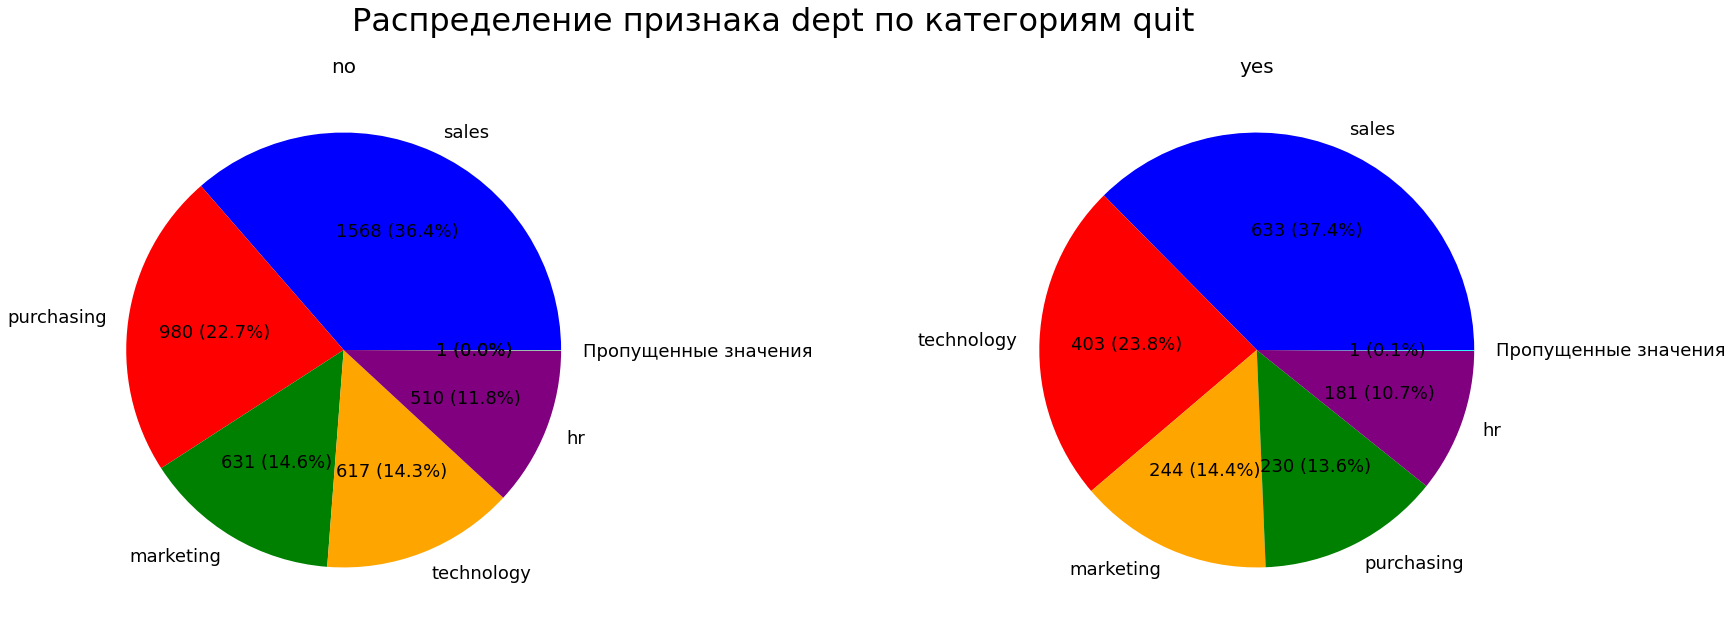

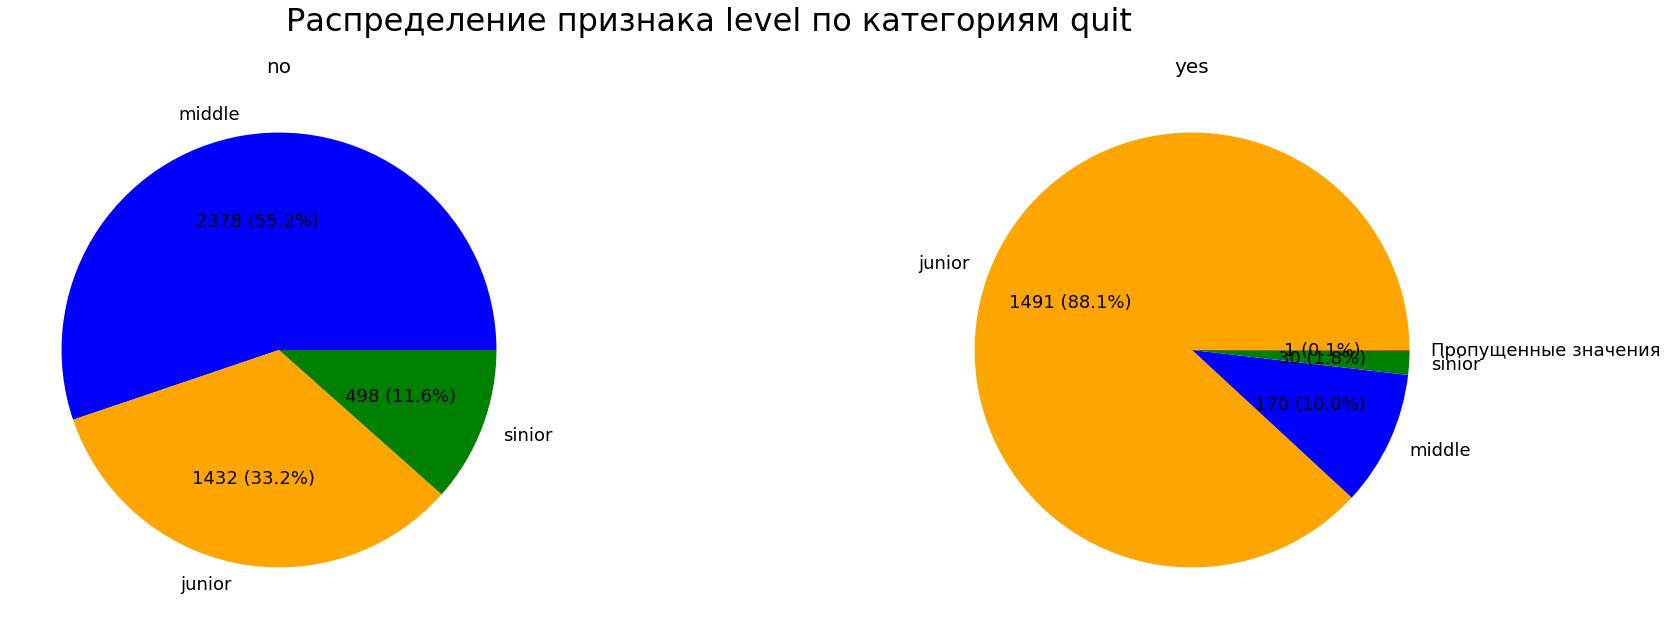

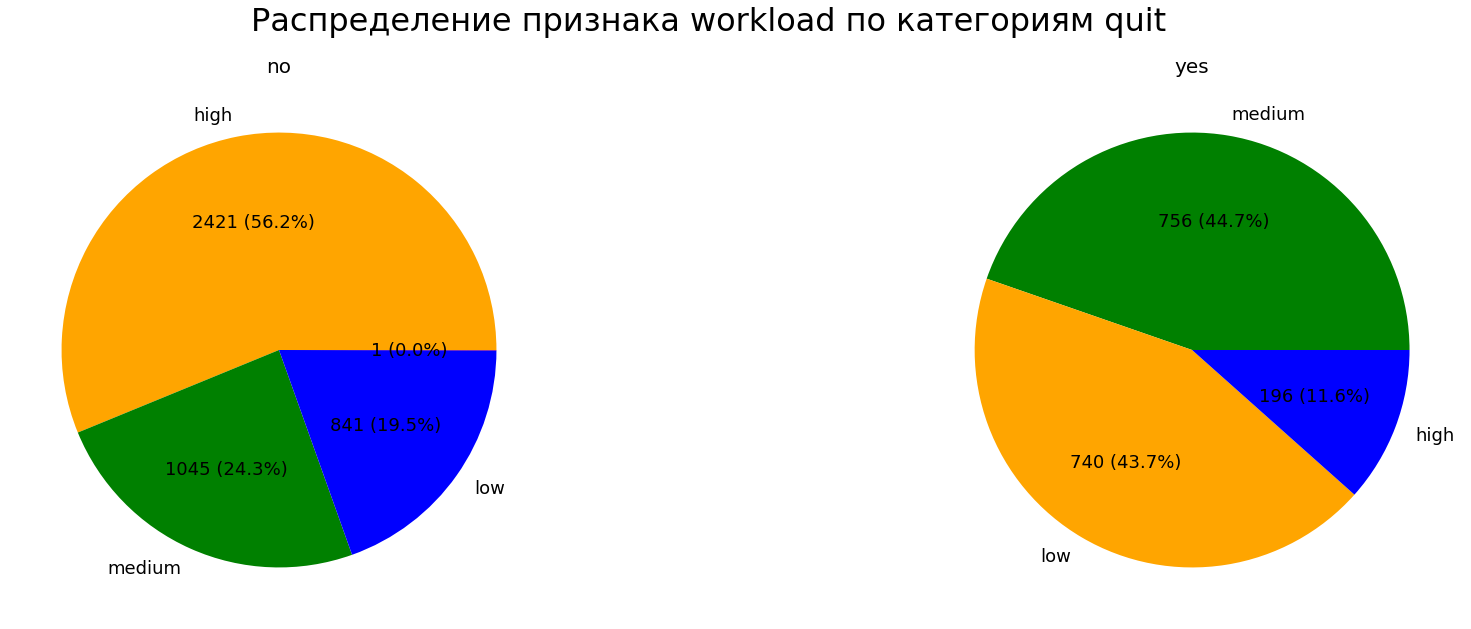

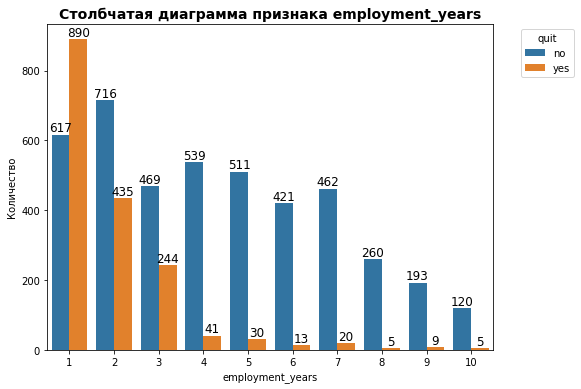

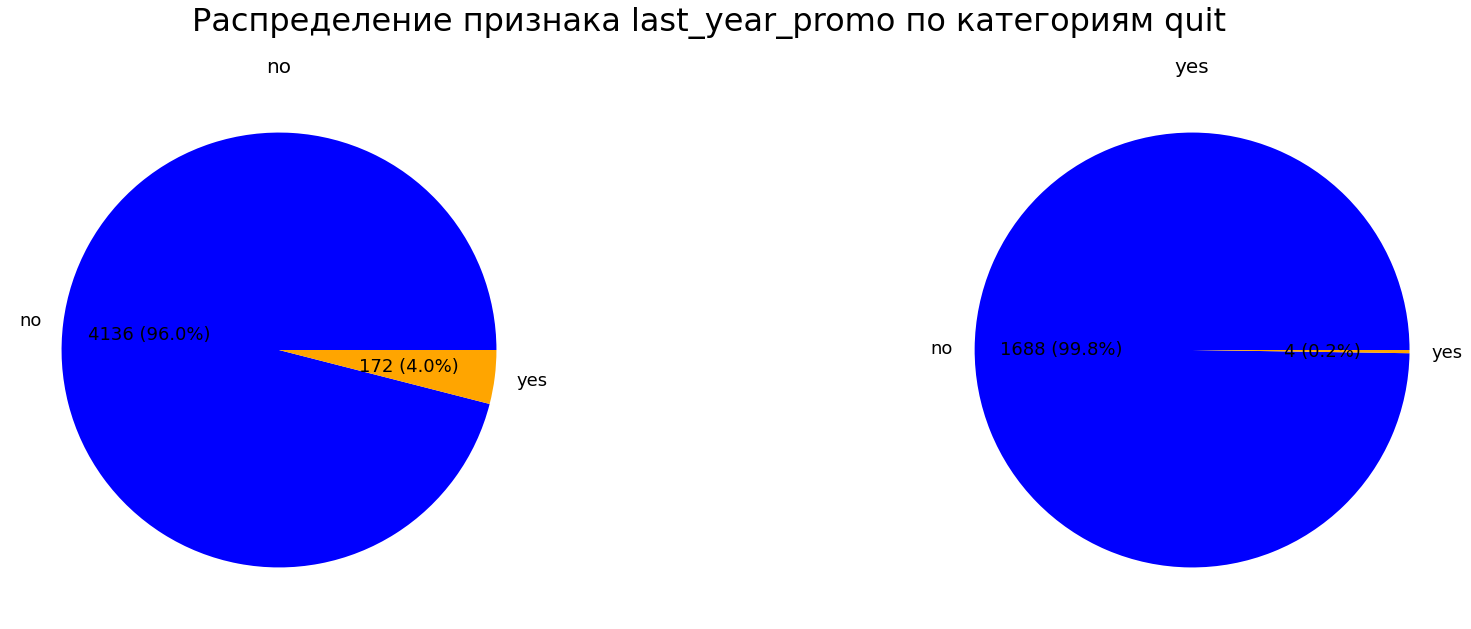

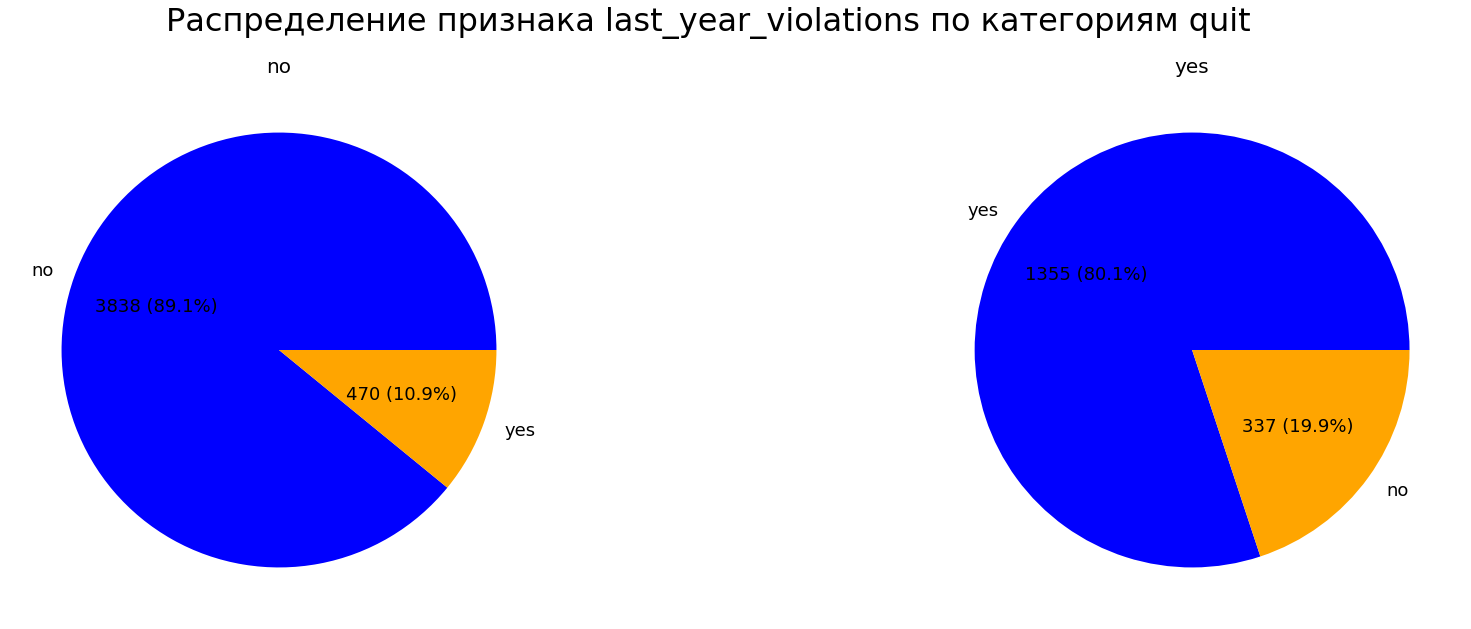

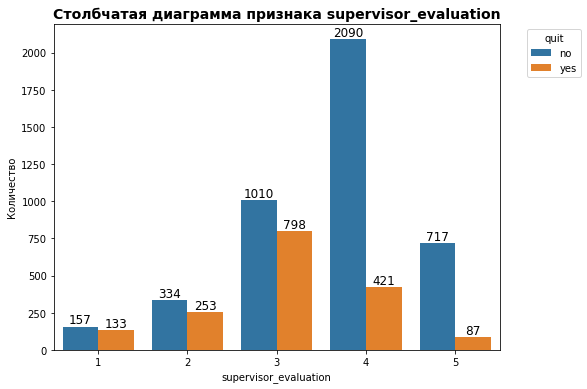

count     6000.000000
mean     33892.800000
std      15234.077185
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64
Среднее значение признака salary в категории no: 37683.28690807799
Среднее значение признака salary в категории yes: 24241.843971631206


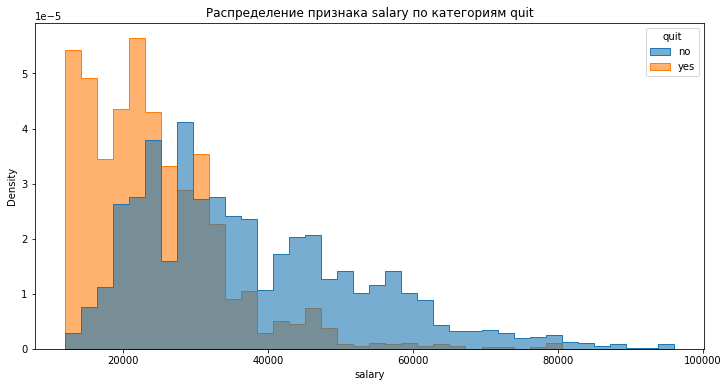

In [96]:
for col in analyze_quit_df.columns:
    if col != 'quit' and col != 'id':
        analyze_col_hue(analyze_quit_df, col, hue='quit')

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

Здесь 2 дискретных признака неверно визуализированы.
</div>

Отметим ключевые отличия уволившихся сотрудников от действующих: 
- Отдел не имеет значения
- Как правило, увольняются джуны. Чаще всего склонны отсаваться middle специалисты
- Нагрузка низкая или средняя
- Увольняются обычно те, кто работают в компании 2 года и менее. Чем больше срок работы, тем меньше вроятность увольнения
- Уволившиеся сотрудники, как правило, не получают повышения в год предшествующий увольнению, что логично, так как это в основном вновь пишедшие сотрудники с начальным уровнем
- Уволившиеся сотрудники чаще нарушают трудовой договор. Возможно, по неопытности, а возможно, просто потому, что не держатся за работу
- Как правило, уволившиеся сотрудники получают более низкие оценки от руководителя
- У уволившихся сотрудников зарплата чаще всего лежит в диапазоне от 10 до 35 тыс.


Составим краткий портрет уволившегося сотрудника: джун, работающий в компании менее 2 лет и за это время не получивший повышения, с низкой нагрузкой. Зарплата находится в диапазоне от 10 до 35 тыс., имеет нарушение трудового догвоора за последний год, имеет никзую оценку руководителя (1-3).

#### Связь удовлетворенности работой и вероятностью увольнения

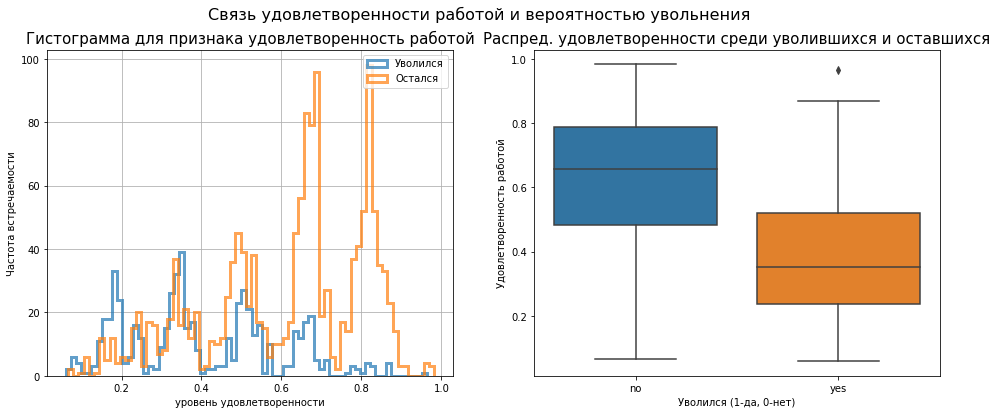

In [97]:
test_df['satisfaction_pred'] = grid.best_estimator_.predict(test_df.drop(['id', 'quit'], axis=1))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
fig.suptitle("Связь удовлетворенности работой и вероятностью увольнения", fontsize=16)

ax[0].set_title('Гистограмма для признака удовлетворенность работой', fontsize=15)

test_df[test_df['quit'] == 'yes'].plot(
    kind='hist',
    y='satisfaction_pred',
    histtype='step',
    bins=70,
    linewidth=3,
    alpha=0.7,
    ax=ax[0],
    label='Уволился',
)

test_df[test_df['quit'] == 'no'].plot(
    kind='hist',
    y='satisfaction_pred',
    histtype='step',
    bins=70,
    linewidth=3,
    alpha=0.7,
    label='Остался',
    ax=ax[0],
    grid=True,
    legend=True,
)
ax[0].set_xlabel('уровень удовлетворенности');
ax[0].set_ylabel('Частота встречаемости');
    
sns.boxplot(x='quit', y='satisfaction_pred', data=test_df, ax=ax[1])
ax[1].set_title('Распред. удовлетворенности среди уволившихся и оставшихся', fontsize=15)
plt.xlabel('Уволился (1-да, 0-нет)')
plt.ylabel('Удовлетворенность работой')
plt.show()



Видно, что есть связь между этими двумя признаками: у уволившихся уровень удовлетовренности в реднем ниже, чем у оставшихся.

**Вывод:**
Был проведен исследвоательский анализ данных. Был выявлен дисбаланс классов в целевом признаке (1:3). В остальном данные подходят для обучения линейных моделей.  
Был составлен портрет уволившегося сотрудника: джун, работающий в компании менее 2 лет и за это время не получивший повышения, с низкой нагрузкой. Зарплата находится в диапазоне от 10 до 35 тыс., имеет нарушение трудового догвоора за последний год, имеет никзую оценку руководителя (1-3).  
Также была выявлен связь между увольнением и удовлетворенностью работой: как правило, уволенные имеют более низкий уровень удовлетовренности работой


<div class="alert alert-warning">
<b>Комментарий 👉</b>

Хорошо! Составлен портрет «ушедшего работника», также есть визуализация и сравнение распределений признака job_satisfaction_rate для ушедших и оставшихся работников, но сравнение без статистического теста, "на глаз".
</div>

### Добавление нового признака

Ранее мы уже добавили этот признак к тестовой выборке. Выделим целевой признак и входные признаки

In [98]:
X_test_2 = test_df.drop(['id', 'quit'], axis=1)
y_test_2 = test_df['quit']

In [99]:
X_test_2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,satisfaction_pred
0,marketing,junior,medium,2,no,no,5,28800,0.883333
1,hr,junior,medium,1,no,no,4,30000,0.682222
2,sales,middle,low,5,no,no,4,19200,0.683750
3,sales,middle,low,6,no,no,4,19200,0.713333
4,hr,middle,medium,5,no,no,5,40800,0.825556


Аналогично с тренировочной выборкой

In [100]:
train_quit['satisfaction_pred'] = grid.best_estimator_.predict(train_quit.drop(['id', 'quit'], axis=1))
X_train_2 = train_quit.drop(['id', 'quit'], axis=1)
y_train_2 = train_quit['quit']

In [101]:
X_train_2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,satisfaction_pred
0,sales,middle,high,2,no,no,4,54000,0.637143
1,sales,junior,medium,2,no,no,4,27600,0.821905
2,purchasing,middle,medium,5,no,no,1,37200,0.337500
3,sales,junior,medium,2,no,yes,3,24000,0.350000
4,marketing,junior,medium,2,no,no,5,25200,0.812500


Также исследуем здесь корреляцию между признаками на тренировочной выборке

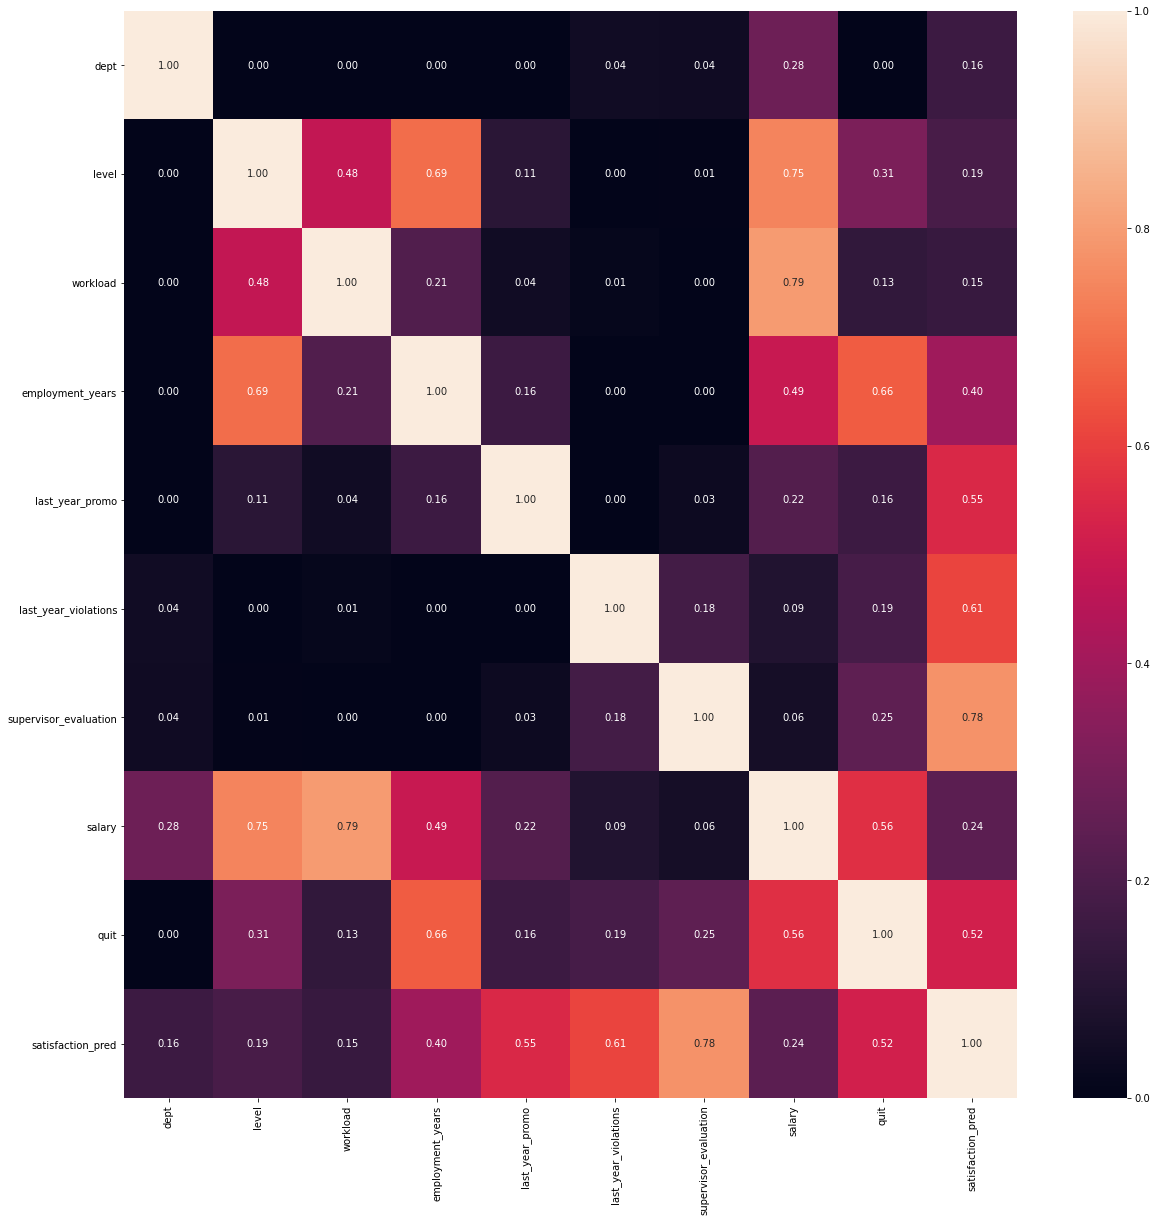

In [103]:
interval_cols = {
    'salary',
    'satisfaction_pred'
}


plt.figure(figsize=(20, 20))

sns.heatmap(
    train_quit.drop('id', axis=1).phik_matrix(
        interval_cols=interval_cols
    ), annot=True, fmt='.2f'
)

plt.show()

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

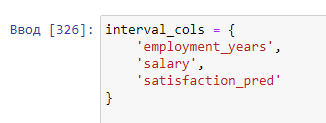

Все ли признаки в interval_cols сейчас действительно непрерывные? Или "затесались" в список ещё и дискретные?
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

Видим, что целевой признак имеет наибольшую корреляцию с предсказанной удовлетворенностью работой, зарплатой и стажем работы в компании

**Вывод:**
Добавлен новый признак в обучающую и тестовую выборки.

### Создание пайплайна

Обозначим столбцы, которые будем подвергать разным видам кодирования и масштабирования. В целом выводы те же, что и впервой части задания.

In [104]:
ohe_columns_2 = [
    'last_year_violations', 
    'last_year_promo',
    'dept'
]
ord_columns_2 = [
    'workload',
     'level'
]
num_columns_2 = ['salary', 'employment_years', 'supervisor_evaluation', 'satisfaction_pred'] 

Далее создадим второй пайплан для кодирования OneHotEncoder

In [105]:
ohe_pipe_2 = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

Аналогично для OrdinalEncoder

In [106]:
ord_pipe_2 = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['low', 'medium', 'high'],
                    ['junior', 'middle', 'sinior']
                    
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Объединим шаги для предобработки данных в единый пайплайн

In [107]:
data_preprocessor_2 = ColumnTransformer(
    [('ohe', ohe_pipe_2, ohe_columns_2),
     ('ord', ord_pipe_2, ord_columns_2),
     ('num', StandardScaler(), num_columns_2)
    ], 
    remainder='passthrough'
)

И дополним его шагом по обучению модели

In [108]:
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

**Вывод:** Пайплайн готов. В нём присутствуют шаги по кодированию и масштабированию данных, а также шаг по созданию модели

### Обучение моделей

В данном случае решается задача классификации. Для обучения используем дерево решений, метод К-ближайших соседей, логистическую регрессию и метод опорных векторов (полиноминальное ядро). Для подбора параметров будем использовать RandomizedSearchCV

In [109]:
param_grid_2 = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1,7),
        'models__max_features': range(1,7),
        'models__min_samples_leaf': range(1,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe__ohe__drop': ['first']
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe__ohe__drop': ['first']
    
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe__ohe__drop': ['first']
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel='poly'
        )],
        'models__degree': range(1,4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe__ohe__drop': ['first']
    }
    
]


Предварительно закодируем целевой признак

In [110]:
label_encoder = LabelEncoder()
y_train_2 = label_encoder.fit_transform(y_train_2)
y_test_2 = label_encoder.transform(y_test_2)

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Кодирование таргета нельзя делать "руками":

- при появлении новых значений категориальных признаков, не предусмотренных твоим решением, модель или упадёт, или будет генерировать ошибки;
- такое решение не сделаешь частью пайплайна, а все современные решения базируются на них.
    
**Поэтому кодирование нужно делать только с применением обучаемых трансформеров. Для кодирования целевого признака нужно использовать LabelEncoder (сокращаю до LE)**: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html.

p.s. если стоит вопрос в том, что тебе не нравиться, что LE, например, присваивает классу "снизилась" метку 0, а "прежний уровень" - метку 1, то значения меток можно инвертировать с помощью небольшого лайфхака:

        import numpy as np

        # Пример преобразованных классов
        target = np.array([0, 1, 1, 0, 1, 0])

        # Инвертирование классов
        inverted_target = 1 - target

        print("Исходные классы:", target)
        print("Инвертированные классы:", inverted_target)

В этом примере переменная inverted_target будет содержать те же значения, что и target, но значения будут инвертированы.

p.p.s. есть ещё метод invert_transform()
</div>

In [112]:
import warnings
warnings.filterwarnings('ignore')
grid_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_grid_2, 
    cv=5,
    scoring='roc_auc', 
    n_jobs=-1,
    n_iter=100
)
grid_2.fit(X_train_2, y_train_2)
print(grid_2.best_estimator_)
print('ROC-AUC для лучшей модели при кросс-валидации: ', grid_2.best_score_)
print('ROC-AUC для лучшей модели на тренировочных данных: ', 
      roc_auc_score(y_train_2, grid_2.best_estimator_.predict_proba(X_train_2)[:, 1]))
print('ROC-AUC для лучшей модели на тестовых данных: ', 
      roc_auc_score(y_test_2, grid_2.best_estimator_.predict_proba(X_test_2)[:, 1]))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                                                  Pipeline(s

<div class="alert alert-warning">
<b>Комментарий 👉</b>



Это НЕ результат на тренировочной выборке. Это результат на кросс-валидации.
</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Здесь хорошо. Расчёт ROC-AUC выполнен верно, через предсказанную вероятности класса 1. Здесь большой процент ошибок я часто вижу (коллеги делают расчет передавая вторым параметром не вероятность а признаки валидационной выборки). 
    
Площадь под ROC-кривой (Area Under Curve – площадь под кривой, Receiver Operating Characteristic – рабочая характеристика приёмника ... пришло из области радиоэлектроники) – это метрика оценки для задач бинарной классификации. ROC-кривая показывает зависимость между долей верно классифицированных объектов положительного класса и долей ложноположительных объектов. Ну и сама площадь под ROC-кривой является мерой качества классификатора: чем выше значение AUC (Area Under Curve), тем лучше качество классификации конкретной модели. Наш глаз и мозг устроены так, что мы очень хорошо видим геометрическую разницу (в данном случае площадей).
</div>

Исследуем влияние признаков на принятие решения моделью

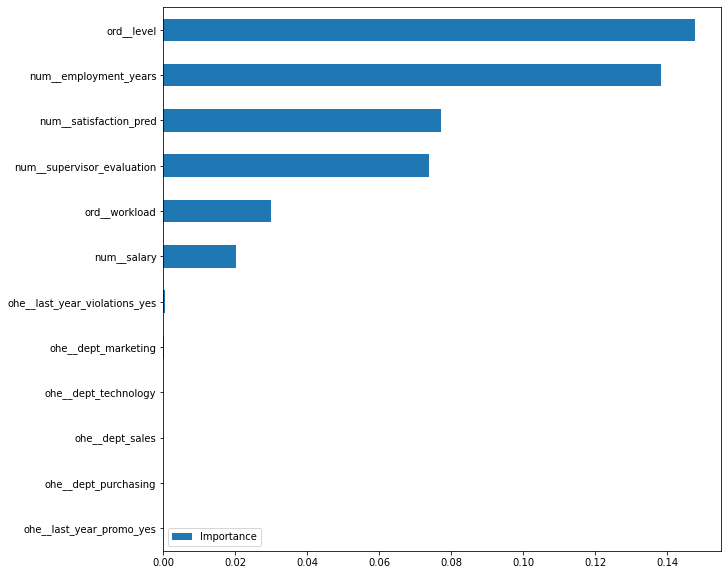

In [113]:
X_train_preprocessed_2 = pipe_final_2.named_steps['preprocessor'].fit_transform(X_train_2)

X_test_preprocessed_2 = pipe_final_2.named_steps['preprocessor'].transform(X_test_2)

feature_names = pipe_final_2.named_steps['preprocessor'].get_feature_names_out()

X_test_preprocessed_2 = pd.DataFrame(X_test_preprocessed_2, columns=feature_names)

result = permutation_importance(grid_2.best_estimator_['models'], X_test_preprocessed_2, y_test_2, scoring='roc_auc')
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(result['importances_mean'])})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 10), ylabel='', xlabel='')
plt.show()

**Вывод:** По итогам обучения наилучшим образом себя показала модель дерева решений с параметрами:
- max_depth=6,
- max_features=4,
- min_samples_leaf=5, 
- random_state=42

Метрики качества:  
ROC-AUC для лучшей модели на тренировочных данных:  0.94  
ROC-AUC для лучшей модели на тестовых данных:  0.92

Опять же сильной стороной этой модели является возможность гибко подбирать большое количество гиперпараметров

Наибольшим влиянием обладают длительность работы в компании, удовлетовренность работой, уровень, зарплата и нагрузка. Поэтому стоит обращать внимнаие на зарплату и нагрузку работника, а также понимать, что отработвашие много лет сотрудники вряд ли уйдут в другое место.

## Общий вывод

В рамках проекта были решены две задачи: 
1. Предсказан уровень удовлетворенности сотрудника работой 
2. Предсказана вероятность увольнения сотрудника

В рамках первой задачи были проведены: 
1. Выгрузка данных и их предобработка  
Состав данных соответствует описанию. В датасетах test_features и train_job_satisfaction_rate были обнаружены пропуски в признаках department и level, они будут заполнены в рамках работы пайплайна
2. Исследовательский анализ данных  
Распределение признаков в тренировочном и тестовом датасетах очень похожи, за исключением отделов сотрудников. Данные по распределению выглядят достоверно, несмотря на выборсы в признаках salary и supervisor_evaluation.  
Утечки целевого признака нет. Наибольший уровень корреляции у целевого признака с оценкой руководителя. Возможно, если сотрудника хорошо оценивает руководитель, то и сотрудник чувствует себя более комфортно.  
При кодировании признаков стоит использовать OneHotEncoder для признаков last_year_violations, last_year_promo и dept, а для кодирования признаков level и workload стоит использовтаь OrdinalEncoder, имея в виду, что признак ранговый
3. Подготовка пайплайна  
Был подготовлен пайплайн, включающий в себя предобработку данных и создание модели машинного обучения
4. Обучение моделей  
Наилучшей моделью стало дерево решений с параметрами:

    - max_depth=14,
    - max_features=11,
    - min_samples_leaf=1,
    - min_samples_split=8,
    - random_state=42  
Численные признаки масштабировались MinMaxScaler, к столбцам 'last_year_violations', 'last_year_promo', 'dept' был применён OneHotEncoder, к остальным категориальным признакам OrdinalEncoder  
Метрики качества при этом равны:
    - SMAPE на тренировочных данных: 10.01%
    - SMAPE на тестовых данных: 13.59%  
Видно, что с увеличиением максимальной глубины дерева метрика возрастатет. Во многом результат у дерева решенйи лучше в силу количества настраиваемых гиперпараметров. Стоит помнить, что в этой задаче много категориальных признаков, которые линейной регрессии трудно обрабатывать. В то время как дерево решений спокойно работает с такими данными

Во второй задаче решались схожие задачи: 
1. Выгружены необходимые данные. Состав соответствует предоставленному описанию. Требуется обработка пропусков, которая будет произведена в пайплайне
2. Проведен исследовательский анализ данных в том числе составление портрета уволившегося сотрудника  
Был выявлен дисбаланс классов в целевом признаке (1:3). В остальном данные подходят для обучения линейных моделей.
Был составлен портрет уволившегося сотрудника: джун, работающий в компании менее 2 лет и за это время не получивший повышения, с низкой нагрузкой. Зарплата находится в диапазоне от 10 до 35 тыс., имеет нарушение трудового догвоора за последний год, имеет никзую оценку руководителя (1-3).
Также была выявлен связь между увольнением и удовлетворенностью работой: как правило, уволенные имеют более низкий уровень удовлетовренности работой  
3. Составлен пайплайн
4. По итогам обучения наилучшим образом себя показала модель дерева решений с параметрами:
    - max_depth=6,
    - max_features=4,
    - min_samples_leaf=5, 
    - random_state=42  
Метрики качества:  
ROC-AUC для лучшей модели на тренировочных данных:  0.94  
ROC-AUC для лучшей модели на тестовых данных:  0.92  
Опять же сильной стороной этой модели является возможность гибко подбирать большое количество гиперпараметров

Общие рекомендации для бизнеса: 
1. Стоит обращать внимание на удовлетворенность сотрудников работой. Особенно в этой связи важно следить за качеством его работы и нарушениями трудового договора - снижение оценки руководителя и появление нарушений может стать маркером снижения уровня удовлетворенности. 
2. Стоит следить за недавно устроившимися джунами. Для повышения мотивации оставаться в компании им можно предлагать дополнительные выплаты или составлять программы для ускоренного повышения в компании.
3. Можно в меньшей степени беспокоиться о сотрудниках, долго работающих в компании, - они лояльны и вряд ли уйдут в отличии от новых сотрудников.
4. Чем ниже уровень подготовки сорудника, тем с большей вероятностью он уйдет. Скорее всего, это связано с поисками себя и своей нишы.

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Дмитрий, спасибо за качественный и детальный финальный вывод, равно как и за ход проекта - действительно содержащий важные рекомендации бизнесу и подводящий топ-менеджмент Заказчика к идеям по "донастройке" бизнеса.

Молодец, выводы проекта выше всяческих похвал. Скурпулёзно, детально, с собственными мыслями и рассуждениями, вдобавок ещё и оформлено ОТЛИЧНО!

</div>

# Результат ревью:

Я отмечаю адекватный уровень твоей программистской подготовки. Ты используешь продвинутые концепции языка Python, библиотеки pandas и одной из основных библиотек машинного обучения sckit-learn. Всё это в целом упрощает твой код и одновременно показывает твой уровень владения инструментами анализа данных и machine learning.

С комментированием никаких проблем нет. Твоих объяснений достаточно для понимания твоими коллегами хода мыслей. Ссылки из брифа проекта в нужных местах также помогают следовать за развитием событий и дают полную информацию касаемо того, что будет происходить в том или ином разделе проекта.

Мне было просто проверять твой проект, потому что он чётко структурирован, с использованием оглавления. 

Зелёным цветом я отметил и прокомментировал удачные и элегантные решения, на которые ты можешь опираться в будущих проектах.

Жёлтым цветом я выделил то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас.

Однако есть принципиальные моменты, которые не позволяют мне принять твой проект в его нынешнем состоянии:

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>
    
1. Ряд признаков в наших данных имеет дискретную природу (например это **employment_years** и **supervisor_evaluation**). Для графического анализа дискретных признаков нужнен тип графиков, который на каждое уникальные значение признака строит свою корзину. Например, можно использовать **sns.countplot** или **.plot(kind='bar')**. Ты же для визуализации их используешь гистограмму.
    
2. Все ли признаки в interval_cols сейчас действительно непрерывные? Или "затесались" в список ещё и дискретные?
</div>

Эти моменты требуют твоего внимания. Комментарии по ним помечены красным цветом. 

Подводя итог: хорошая работа на самом-то деле, молодец! Есть несколько моментов к исправлению, но уверен, что они не вызовут у тебя сложностей. После доработки обязательно проверь комментарии и выводы. Их нужно будет скорректировать. Жду доработанную версию проекта на повторное ревью.

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Александр, большое спасибо тебе за подробные комментарии! С удовольствием прочитал, подчерпнул для себя много нового. Особенно спасибо за эссе по удалению/спасению данных, очень полезно. Замечания исправил в работе, старался оставлять ответные </font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b>

Дмитрий, был рад помочь! Был рад работать с тобой совместно над проектом! ПРОЕКТ ПРИНЯТ!
    
p.s. загляни сейчас в эл/почтовый ящик ...    
</div>
